# Простой генетический алгоритм

Для родственных моделей

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [65]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import numpy as np
import random
import copy
from functools import reduce

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [104]:
def print_NRS_graph(model, ax=None):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС с позициями
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        # nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        # nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        nc = [colors[e.id] for e in model.elmnts]
        if ax:
            nx.draw(G, pos=pos, with_labels=True, node_color=nc, ax=ax)
        else:
            nx.draw(G, pos=pos, with_labels=True, node_color=nc)

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model, ax=None):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nc = [colors[e.id] for e in model.elmnts]
    if ax:
        nx.draw(G, with_labels=True, node_color=nc, ax=ax)
    else:
        nx.draw(G, with_labels=True, node_color=nc)

    return G

def plot_nrs_compare(m1, m2):
    _, [ax1, ax2] = plt.subplots(1,2, figsize=(14,4))
    print_NRS_graph(m1, ax=ax1)
    print_NRS_graph(m2, ax=ax2)
    ax1.set_title('Было')
    ax2.set_title('Стало')
    plt.show()

# from workFolder.nrs import q_out_simple

#=========================================== Классы модели ГА ==============================================
class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)
        name_prefixes={
            'GA_Element_Pump': 'Н',
            'GA_Element_Hose': 'НРЛ',
            'GA_Element_InHose': 'ВРЛ',
            'GA_Element_Splitter': 'Р', 
            'GA_Element_Joiner': 'ВС',
            'GA_Element_Nozzle': 'С',
        }
        if elmnt.name=='': elmnt.name=name_prefixes[elmnt.id]+str(self.counter)
            
        return super().appendElement(elmnt)
       
    def insertElement(self, elmnt:Element, elmntInsert:Element, pos=0):
        '''
        Вставка элемента в модель НРС.

        `elmnt`: Element
            Элемент относительно которого нужно вставить. Если не указан, вставляется элемент по правилам.

        `pos`: int
            Позиция: 0 - до элемента, 1 после.
        '''

        # До элемента
        if pos==0:
            logger.debug('Вставка до')
            if len(elmnt.elements_previous)>0:
                elmnt_in = random.choice(elmnt.elements_previous)
                elmnt.elements_previous.remove(elmnt_in)
                elmnt_in.elements_next.remove(elmnt)
                # print(type(elmntInsert))

                elmnt_in.append(elmntInsert).append(elmnt)
        # После элемента
        elif pos==1:
            logger.debug('Вставка после')
            if len(elmnt.elements_next)>0:
                elmnt_to = random.choice(elmnt.elements_next)
                elmnt.elements_next.remove(elmnt_to)
                elmnt_to.elements_previous.remove(elmnt)

                elmnt.append(elmntInsert).append(elmnt_to)            

        self.addElements([elmntInsert])
        
        return self

    def get_random_element_by_class(self, lst, clss):
        elmnt = None
        if element_class_test(lst, clss):
            while not isinstance(elmnt, clss):
                elmnt = random.choice(lst)
        else:
            elmnt = None
        return elmnt

    def getNewElement(self, elmnt:Element, pos=0):
        '''
        Правила добавления новых элементов
        '''
        if pos==0:
            e_class = allowed_prepend_classes[elmnt.id]
        elif pos==1:
            e_class = allowed_append_classes[elmnt.id]
        if isinstance(e_class, tuple):
            if len(e_class)>0:
                return random.choice(e_class)('', e_type=1)
            else:
                return None
        return e_class('', e_type=1)


    def crossing(self, pair_model, change_val=0.5):
    # def cross(mdl1, mdl2, change_val=0.5):
        cross_size = int(len(self.elmnts)*change_val)
        # скрещивание постоянных элементов
        # for elmnt1, elmnt2 in zip(mdl1.elmnts[cross_size:],mdl2.elmnts[cross_size:]):
        #     elmnt1.copy_props(elmnt2)
        # скрещивание случайных элементов
        elmnts_for_copy = random.sample(range(len(self.elmnts)), cross_size)
        for ei in elmnts_for_copy:
            elmnt1 = self.elmnts[ei]
            elmnt2 = pair_model.elmnts[ei]
            elmnt1.copy_props(elmnt2)
            # try:
            #     elmnt1 = self.elmnts[ei]
            # except IndexError as e:
            #     print(e)
            #     print(elmnt1.name, elmnt2.name, ei, elmnts_for_copy)
            # try:
            #     elmnt2 = pair_model.elmnts[ei]
            # except IndexError as e:
            #     print(e)
            #     print(elmnt1.name, elmnt2.name, ei, elmnts_for_copy)
            # try:
            #     elmnt1.copy_props(elmnt2)
            # except:
            #     print(elmnt1.name, elmnt2.name, ei, elmnts_for_copy)
        return self


    # def mutate(self, mutation_count=1, mutation_var=None, mutation_weights=[8,1,1,1,1]):
    def mutate(self, mutation_count=1, mutation_var=None, mutation_weights=[1,0,0,0,0]):
        '''
        Мутация элементов модели
        '''

        # Мутации
        for _ in range(mutation_count):
            if mutation_var:
                var = mutation_var
            else:
                # var = random.choice([0,1,2,3,4])
                var = random.choices([0,1,2,3,4], weights=mutation_weights)[0]

            # Микромутации
            if var==0:
                random.choice(self.elmnts).mutate()
            # Макромутации
            # удаление элемента
            if var==1:
                logger.debug('удаление элемента')
                self.delElement(random.choice(self.elmnts))
            # замена элемента
            if var==2:
                logger.debug('замена элемента')
                # pump <-> joiner <-> splitter
                # nozzle -> splitter
                elmnt_classes = [GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter, GA_Element_Nozzle]
                elmnt_class = random.choice(
                    elmnt_classes
                    )
                # elmnt = pop_random_element_by_class(self.elmnts, elmnt_class)
                elmnt = self.get_random_element_by_class(self.elmnts, elmnt_class)
                if elmnt:
                    logger.debug('Заменяется', elmnt.name)
                    if isinstance(elmnt, elmnt_classes[0]):
                        # Если насос:
                        if random.choice([True,False]):
                            # В разветвление:
                            new_elmnt = GA_Element_Splitter('', e_type=1, ri=1, ro=elmnt.ro)
                        else:
                            # В водосборник
                            new_elmnt = GA_Element_Joiner('', e_type=1, ri=elmnt.ri, ro=1)
                    elif isinstance(elmnt, elmnt_classes[1]):
                        # Если водосборник
                        # В насос
                        new_elmnt = GA_Element_Pump('', e_type=1, H_add=40)
                    elif isinstance(elmnt, elmnt_classes[2]):
                        # Если разветвление
                        if random.choice([True,False]):
                            # В насос
                            new_elmnt = GA_Element_Pump('', e_type=1, H_add=40)
                        else:
                            # В ствол (пока только А)
                            new_elmnt = GA_Element_Nozzle('', e_type=2, n_type='А', p=NRS_Revision.calc_p(7.4, 40), q_out = q_out_nozzle)
                    elif isinstance(elmnt, elmnt_classes[3]):
                        # Если ствол
                        # В разветвление
                        new_elmnt = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
                        new_hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
                        new_nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out = q_out_nozzle)
                        new_elmnt.append(new_hose).append(new_nozzle)
                        self.addElements([new_hose, new_nozzle])

                    elmnts_next = elmnt.elements_next
                    elmnts_prev = elmnt.elements_previous
                    self.delElement(elmnt, fire_dead_elements=False)
                    new_elmnt.add_links(elmnts_prev, elmnts_next)
                    self.addElements([new_elmnt])
                    logger.debug(new_elmnt, type(new_elmnt), new_elmnt.name)
                        

            # вставка элемента
            if var==3:
                logger.debug('вставка элемента')
                elmnt = random.choice(self.elmnts)
                pos = random.choice([0,1])
                new_elmnt = self.getNewElement(elmnt, pos)
                if new_elmnt:
                    self.insertElement(elmnt, new_elmnt, pos)
            # добавление ветви из пресета
            if var==4:
                logger.debug('добавление ветви')
                # Определяем какие есть входы и выходы и исходя из этого добавляем ветвь нужного типа
                # elmnt = pop_random_element_by_class(self.elmnts, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter), lst_left=True)
                # elmnt = None
                # if element_class_test(self.elmnts, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter)):
                #     while not isinstance(elmnt, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter)):
                #         elmnt = random.choice(self.elmnts)
                # else:
                #     elmnt = None
                elmnt = self.get_random_element_by_class(self.elmnts, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter))
                if elmnt:
                    if elmnt.ro > len(elmnt.elements_next):
                        logger.debug('0', elmnt.name)
                        new_hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
                        new_nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out = q_out_nozzle)
                        elmnt.append(new_hose).append(new_nozzle)
                        self.addElements([new_hose, new_nozzle])
                    elif elmnt.ri > len(elmnt.elements_previous):
                        logger.debug('1', elmnt.name)
                        new_pump = GA_Element_Pump('', e_type=0, H_add=40)
                        new_hose = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
                        new_pump.append(new_hose).append(elmnt)
                        self.addElements([new_pump, new_hose])
            
            # Если несколько компонентов;
            # соединение выход -> вход

            # соединение вход -> выход

        return self


    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    
    def check_dead_elements(self):
        for elmnt in self.elmnts:
            self.fire_dead_elements_try(elmnt)
        return self



#======================================Модели элементов=======================================
class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add>=self.H_min and H_add<=self.H_max:
            self.H_add = H_add
        elif H_add > self.H_max:
            # print("---", self.H_add, self.H_max)
            self.H_add = self.H_max
        elif H_add <= self.H_min:
            self.H_add = self.H_min


    def mutate(self):
        # mutation_case = random.choices([0,1,2,3],weights=[4,2,1,1])[0]
        mutation_case = random.choices([0,1,2,3],weights=[4,1,0,0])[0]
        # мутация напора
        if mutation_case==0:
            change_val = random.choice([-5,5])
            # print('H added')
            self.set_H_add(self.H_add+change_val)
        # Мутация производительности насоса
        if mutation_case==1:
            change_val = random.choice([40,60,70,100])
            self.Q_max = change_val
        # Мутация количества напорных патрубков
        if mutation_case==2:
            change_val = random.choice([2,4])
            self.set_ro(change_val)
        # Мутация всасывающих патрубков
        if mutation_case==3:
            change_val = random.choice([1,2,3,4])
            self.set_ri(change_val)

    def set_q(self, q):
        '''
        Устанавливает расход для текущего элемента,
        а так же далее запускает рекурсивный перерасчет расходов 
        для всех предыдущих относительно текущего элементов.\n
        Для каждого элемента происходит суммирование в том случае,
        если элемент является водосборником \n
        Если к элементу подключено несколько других элементов на вход
        Расход к ним разделяется поровну (в данной реализации).
        '''
        self.q+=q
        if self.q > self.Q_max:
            raise ValueError("Требуемый расход насоса слишком велик! Такое сочетание параметров неприемлемо!")

        for elmnt in self.elements_previous:
            elmnt.set_q(q/len(self.elements_previous))

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.set_H_add(elmnt.H_add)
        self.Q_max = elmnt.Q_max

        return self


class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0.13, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-10,10)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
    
    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.n = elmnt.n
        self.d = elmnt.d
        self.s = elmnt.s
        
        return self

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        
        return self

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # # мутация количества выходов
        # change_val = random.choice([2,3,4,5])
        # self.set_ro(change_val)
        pass

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.set_ro(elmnt.ro)
        
        return self

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества входов
        # change_val = random.choice([2,3,4,5])
        # self.set_ri(change_val)
        pass

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.set_ri(elmnt.ri)
        
        return self

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # mutation_case = random.choice([0,1])
        # Мутация типа ствола
        change_val = random.choice(['А','Б','Л'])
        self.n_type = change_val
        if change_val=='А':
            self.p = NRS_Revision.calc_p(7.4, 40)
        if change_val=='Б':
            self.p = NRS_Revision.calc_p(3.7, 40)
        if change_val=='Л':
            self.p = NRS_Revision.calc_p(16, 40)

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.p = elmnt.p
        self.n_type = elmnt.n_type
        
        return self

# Правила соединения элементов
# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }


#=====================================Оценщик=====================================================================================================
class Appraiser(NRS_Revision):
    '''
    Класс-оценщик состояния модели
    '''
    
    @staticmethod
    def print_GA_NRS_model_elements_state(model:GA_model):
        print('='*80)
        print(model.name)
        print('='*80)
        
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                print(f'Насос ({elmnt.name}); напор: {elmnt.H_add} м; производительность: {elmnt.q} л/с; напор макс.: {elmnt.H_max}')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                print(f'Рукавная линия ({elmnt.name}), длина: {elmnt.get_L()} м; диаметр: {elmnt.d} мм; сопротивление {elmnt.s}; расход: {elmnt.q} л/с; потеря напора: {elmnt.h} м')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Nozzle):
                print(f'Ствол ({elmnt.name}): "{elmnt.n_type}"; проводимость: {elmnt.p}; напор: {elmnt.H_in}, м; расход: {elmnt.q}, л/с')

    @staticmethod
    def get_G(model:GA_model):
        G = nx.DiGraph()

        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())
        
        return G
    
    @staticmethod
    def get_Ls(G, model:GA_model):
        ''' 
        Расчет расстояний до элементов

        # Возвращает

        `p`: dict, `min_L`:float, `max_L`:float
            `p` - Словарь словарей, где ключ1 - имя насоса, ключ2 - имя ствола, значение - расстояние до него в метрах.
            `min_L` - Минимальное расстояние из имеющихся, м.
            `max_L` - Максимальное расстояние из имеющихся, м.
        '''
        max_L=0
        min_L=100000
        nozzles_names = [n.name for n in model.elmnts_out if n.type==2]
        p={}
        for e_pump in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = e_pump.name, weight='L')
            dists = {k:v for k,v in paths.items() if k in nozzles_names}  
            p[e_pump.name] = dists
            cur_max_L = max(dists.values())
            cur_min_L = min(dists.values())
            if cur_max_L>max_L: max_L=cur_max_L
            if cur_min_L<min_L: min_L=cur_min_L
        return p, min_L, max_L
    
    @staticmethod
    def metrics(model:GA_model):
        '''
        Оценка модели
        '''
        m={'hoses':0,'nozzles':0}
        # Расчет длинн рукавных линий
        G = Appraiser.get_G(model)
        m['distances'], m['min_L'], m['max_L'] = Appraiser.get_Ls(G, model)        

        # Количество рукавов
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                m['hoses']+=elmnt.n
                try:
                    m[elmnt.d]+=elmnt.n
                except:
                    m[elmnt.d]=elmnt.n
            if isinstance(elmnt, GA_Element_Nozzle):
                m['nozzles']+=elmnt.n
                try:
                    m[elmnt.n_type]+=1
                except:
                    m[elmnt.n_type]=1
        
        # Общий расход
        m['Q'] = model.summaryQ()

        return m
    
    @staticmethod
    def print_metrics(model:GA_model):
        for k, v in Appraiser.metrics(model).items():
            print(k,v, sep='\t')

    @staticmethod
    def evaluate(metrics: dict, aims: dict, aims_not_more=None, aims_not_less=None):
        '''
        Оценка модели

        `metrics`: dict
            Словарь метрик модели
        `aims`: dict
            Словарь целей оптимизации
        `aims_not_more`: dict
            Словарь целей оптимизации значения которых не могут быть выше некоторого значения.
            Например, если в модели не должно присутствовать более 10 рукавов диаметром 77мм.
        ''' 
        X = []
        Y = []
        for aim, aim_val in aims.items():
            if aim in metrics.keys():
                metric_val = metrics[aim]
                max_val = max(aim_val, metric_val)
                X.append(metric_val/max_val)
                Y.append(aim_val/max_val)
        if aims_not_more:
            # Цели "не более"
            for aim, aim_val in aims_not_more.items():
                if aim in metrics.keys():
                    metric_val = metrics[aim]
                    if metric_val>aim_val:
                        max_val = max(aim_val, metric_val)
                        X.append(metric_val/max_val)
                        Y.append(aim_val/max_val)
        if aims_not_less:
            # Цели "не менее"
            for aim, aim_val in aims_not_less.items():
                if aim in metrics.keys():
                    metric_val = metrics[aim]
                    if metric_val<aim_val:
                        max_val = max(aim_val, metric_val)
                        X.append(metric_val/max_val)
                        Y.append(aim_val/max_val)                        

        # Собственно оценка!
        z=[]
        for x,y in zip(X,Y):
            z.append(abs(y-x))

        return np.mean(z)





#======================================================Дополнительные инструменты=================================================================
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        idx = lst.index(elmnt)
        return copy.deepcopy(lst.pop(idx))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()


#==============================================Рекурсии=========================================================================
# Рекурсивное построение дерева
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)


def fire_dead_elements_try(model:NRS_Model, elmnt: Element):
    '''
    Рекурсивная попытка удалить мертвые элементы из модели
    '''
    print(elmnt.name)
    if elmnt.type==0 and len(elmnt.elements_next)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==1 and (len(elmnt.elements_next)==0 or len(elmnt.elements_previous)==0):
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==2 and len(elmnt.elements_previous)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        model.delElement(elmnt)
    return model


#==================================================== Класс ветви =================================================
class Branch(NRS_Model):
    '''
    Класс ветви модели. Может быть трех типов:

    `FULL=0` Имеет и источник и потребитель (насос и ствол).
        Например простая модель НРС АЦ->Рукав->Ствол.

    `INWARD=1` Имеет только вход. Выход открыт (оканчивается рукавом)
        Например, Рукавные линии начинающиеся от насосов. Могут подключаться на вход к водосборникам или насосам.

    `OUTWARD=2` Имеет только выход. Вход открыт (начинается с рукава). 
        Например, рабочие рукавные линии. Могут подключаться на выход к разветвлениям или насосам.

    `-1` Не распознана.
    '''

    def __init__(self, name=''):
        self.elmnts_names = []
        self._branch_type = -1
        super().__init__(name)

    def getBranch(self, model:NRS_Model, elmnt=None):
        '''
        Из `model` выделяется ветвь в которую входит элемент `elmnt`. 
        Если `elmnt` не передан, он выбирается случайно.
        '''
        # Если элемент не передан, выбираем его случайным образом
        if elmnt is None:
            elmnt = random.choice(model.elmnts)
        # Если передано имя элемента, получаем его по имени, иначе предполагается использование объекта
        if isinstance(elmnt, str):
            elmnt = model.getElement(elmnt)
        if not isinstance(elmnt, Element):
            raise TypeError('Должен быть элемент НРС!')

        self._elementAdd(elmnt)

        return self
    
        
    def _elementAdd(self, elmnt:Element):
        '''
        Рекурсивное добавление элементов в модель
            Вход:
                elmnt=Element: элемент который следует добавить модель. 
                Далее _elementAdd будет вызвана для всех подключенных к нему элементов
        '''
        if not elmnt in self.elmnts:
            self.addElements([elmnt])
            for linked in elmnt.elements_next:
                if isinstance(linked, (GA_Element_Hose, GA_Element_Nozzle)):
                    self._elementAdd(linked)
            for linked in elmnt.elements_previous:
                if isinstance(linked, (GA_Element_Hose, GA_Element_Pump)):
                    self._elementAdd(linked)

    def interpretate(self):

        super().interpretate()
        # Определение типа ветви
        if len(self.elmnts_in)>0 and len(self.elmnts_out)>0:
            self._branch_type = 0
        elif len(self.elmnts_in)>0 and len(self.elmnts_out)==0:
            self._branch_type = 1
        elif  len(self.elmnts_in)==0 and len(self.elmnts_out)>0:
            self._branch_type = 2
        # Определение входных элементов
        for elmnt in self.elmnts:
            if len(self.elmnts_in) + len(self.elmnts_out) ==1:
                self.plugin = elmnt

        return self
    
    @property
    def branch_type(self):
        t = {0:'ПОЛНАЯ', 1:'ВХОДЯЩАЯ', 2:'ИСХОДЯЩАЯ', -1:'НЕ РАСПОЗНАНО'}
        return t[self._branch_type]
    
    def deep_copy(self):
        '''
        Делает глубокую копию элементов. Требуется для удаления связей с исходной моделью.
        '''
        tmp_col = []
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            tmp_col.append(copy.deepcopy(elmnt).drop_links())
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            elmnt_copy = NRS_Revision.get_element_by_name(tmp_col, elmnt.name, False)
            for linked in elmnt.elements_next:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    elmnt_copy.append(linked_copy)
            for linked in elmnt.elements_previous:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    linked_copy.append(elmnt_copy)

        self.elmnts = tmp_col
        
        return self
    
    def drop_names(self):
        '''
        Обезличивает (удаляет имена) элементов ветви.
        Требуется для корректной передачи в другие модели, где элементы будут переименованы в соответствии с моделью.
        '''
        for elmnt in self.elmnts:
            elmnt.name = ''
        return self
    
    def plug(self, elmnt):
        '''
        Прививает ветвь к указанному элементу.

        Если ветвь входящая, то прививается на вход (если возможно). 
        Если исходящая - на выход (если возможно)
        Если полная или нераспознанная, ничего не происходит
        '''
        # ВХОДЯЩАЯ
        if self._branch_type==1:
            self.plugin.append(elmnt)
        # ИСХОДЯЩАЯ
        if self._branch_type==2:
            elmnt.append(self.plugin)

        return self

# Пресеты

In [68]:
class Presets():

    @staticmethod
    def single_line():
        '''
        Простая НРС с одной РРЛ и одним стволом

            |=|>-------------|->
        '''
        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)

        pump.append(hose).append(nozzle)

        model = GA_model('Простая НРС с одной РРЛ и одним стволом')
        model.addElements([pump,hose,nozzle])
        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_splitter(nozzles_count=3):
        '''
        Сложная НРС с одним разветвлением и nozzles_count рабочих линий

                             ------|->
            |=|>------{------|->
                             ------|->
            
        '''
        if not nozzles_count in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с одним разветвлением и nozzles_count рабочих линий')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM).append(spliiter)

        model.addElements([pump,hoseM,spliiter])

        for _ in range(nozzles_count):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def two_splitter(nozzles_count1=2, nozzles_count2=2):
        '''
        Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка

                             ------|->          ------|->
            |=|>------{------------------{------|->
                             ------|->          ------|->
            
        '''
        if not nozzles_count1 in [1,2]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 2!")
        if not nozzles_count2 in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter1 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter2 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM1).append(spliiter1).append(hoseM2).append(spliiter2)

        model.addElements([pump,hoseM1,spliiter1,hoseM2,spliiter2])

        for _ in range(nozzles_count1):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter1.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        for _ in range(nozzles_count2):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter2.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        
        return model.check_pumps().interpretate()

    @staticmethod
    def single_joiner(nozzle_q=20, nozzle_workpress=60):
        '''
        Сложная НРС с одним водосборником и лафетным стволом

            |=|>------
                             }------|-,->
            |=|>------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        pump2 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner)
        pump2.append(hoseM2).append(joiner)
        joiner.append(hoseW1).append(nozzle)

        model.addElements([pump1,hoseM1,pump2,hoseM2,joiner,hoseW1,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_pump_to_joiner_by2(nozzle_q=20, nozzle_workpress=60):
        '''
        Простая НРС с одним, насосом, водосборником и лафетным стволом

                    ------
            |=|>...............}------|-,->
                    ------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=1)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner).append(hoseW).append(nozzle)
        pump1.append(hoseM2).append(joiner)

        model.addElements([pump1,hoseM1,hoseM2,joiner,hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def n_components(n=2):
        '''
        Простая НРС из n компонентов в виде простых НРС

            n * |=|>-------------|->
            
        '''
        model = GA_model(f'Простая НРС из {n} компонентов в виде простых НРС')

        for _ in range(n):
            for e in Presets.single_line().elmnts:
                e.name=''
                model.addElements([e])

        return model.check_pumps().interpretate()

# Тесты

In [19]:
def fit(model, aims, aims_not_more=None, aims_not_less=None, epochs=1000, 
        accuracy=0.05, mutation_weights=[20,1,1,1,1], mutation_count=1):
    '''
    Функция обучения одной модели (тестовая)
    '''
    curQ = Appraiser.evaluate(Appraiser.metrics(model), aims, aims_not_more)
    for i in range(epochs):
        print(f'{i}\t', end='\r')
        model_back = copy.deepcopy(model)
        # print(f'{i}\t', len(model_back.elmnts))
        try:
            # model.mutate(mutation_count=2)
            model.mutate(mutation_count=mutation_count, mutation_weights=mutation_weights)          #mutation_count=1, mutation_var=None, mutation_weights=[8,1,1,1,1]
            model.check_pumps().interpretate().check_dead_elements()
            for elmnt in model.elmnts:
                model.fire_dead_elements_try(elmnt)
            model.drop_q()
            kwargs = model.calc(accuracy=accuracy)
            newQ = Appraiser.evaluate(Appraiser.metrics(model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less)
            if newQ<curQ:
                curQ=newQ
                print(i, newQ, model.summaryQ(), sep='\t')
                # plot_nrs_compare(model_back, model)
            else:
                model = model_back
        except:
            # print(i, 'Модель не жизнеспособна')
            model = model_back

    print('Итог:', curQ, model.summaryQ(), sep='\t')
    return model

## Скрещивание

### Тест скрещиваний

Здесь скрещиваем модели с заведомо одинаковой формой

In [74]:
aims = {'38дв':0, '51нп':0, '66нп':0, '89':0,'110': 0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'max_L': 800}
aims_not_more = {'150': 20}
aims_not_less = {'min_L': 700, 'Q':30}

# Модель №1
model1 = fit(Presets.single_splitter(3), 
             aims, aims_not_more, aims_not_less, 
             epochs=1000, 
             mutation_weights=[1,0,0,0,0], 
             mutation_count=10)

# Модель №2
model2 = fit(Presets.single_splitter(3), 
             aims, aims_not_more, aims_not_less, 
             epochs=1000, 
             mutation_weights=[1,0,0,0,0], 
             mutation_count=10)

# Печать данных
Appraiser.print_GA_NRS_model_elements_state(model1)
Appraiser.print_GA_NRS_model_elements_state(model2)

print("Точность 1 модели:", 
        Appraiser.evaluate(Appraiser.metrics(model1), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print("Точность 2 модели:", 
        Appraiser.evaluate(Appraiser.metrics(model2), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
1	0.533882163183512	13.50556898940713
37	0.5070977899663714	16.719693775463995
52	0.45824822794172015	22.58164121842215
350	0.44500811944540075	25.777597095123333
385	0.43556555701664934	26.910704586573505
430	0.4258437056854686	26.577326746315197
448	0.423802959826199	24.250787677998982
698	0.4185548231740872	25.20199264768096
Итог:	0.4185548231740872	25.20199264768096
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
1	0.8483349695262827	13.378375085417495
3	0.8230746388567916	22.574518457195545
4	0.7618864662185656	27.14560149578658
12	0.648474568389491	25.300243313004923
44	0.631569092794174	27.836064652302483
61	0.6175980008469847	26.181728444380873
67	0.580523436091015	20.492913157776307
73	0.563087534129748	23.108298451966366
101	0.5383653584263832	26.81662480747107
158	0.525812516706029	15.735265351238496
169	0.5127432064625075	17.69566188776673
177	0.4371552521888365	24.81

In [24]:
# Appraiser.print_GA_NRS_model_elements_state(model1)
# print('='*80)
Appraiser.print_metrics(model1)
print("Точность 1 модели:", 
        Appraiser.evaluate(Appraiser.metrics(model1), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('='*80)
Appraiser.print_metrics(model2)
print("Точность 1 модели:", 
        Appraiser.evaluate(Appraiser.metrics(model2), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('='*80)

aims

hoses	39
nozzles	3
distances	{'Н0': {'С4': 300, 'С8': 340, 'С6': 500}}
min_L	300
max_L	500
150	15
Л	2
77	24
Б	1
Q	29.932481528299476
Точность 1 модели: 0.3205031301213139
hoses	23
nozzles	3
distances	{'Н0': {'С6': 260, 'С8': 260, 'С4': 420}}
min_L	260
max_L	420
150	13
77	9
Б	2
38	1
Л	1
Q	29.483585405549892
Точность 1 модели: 0.3378886197889157


{'38дв': 0,
 '51нп': 0,
 '66нп': 0,
 '89': 0,
 '110': 0,
 '150': 10,
 '200': 0,
 '225': 0,
 '250': 0,
 '300': 0,
 'max_L': 800}

### Тест скрещивания модели

In [77]:
def cross(mdl1, mdl2, change_val=0.5):
    cross_size = int(len(mdl1.elmnts)*change_val)
    # скрещивание постоянных элементов
    # for elmnt1, elmnt2 in zip(mdl1.elmnts[cross_size:],mdl2.elmnts[cross_size:]):
    #     elmnt1.copy_props(elmnt2)
    # скрещивание случайных элементов
    elmnts_for_copy = random.sample(range(len(mdl1.elmnts)), cross_size)
    for ei in elmnts_for_copy:
        elmnt1 = mdl1.elmnts[ei]
        elmnt2 = mdl2.elmnts[ei]
        elmnt1.copy_props(elmnt2)
    return mdl1

wmodel1 = copy.deepcopy(model1)
wmodel2 = copy.deepcopy(model2)

wmodel1 = cross(wmodel1, wmodel2)       #Добавить мутацию
wmodel1.calc(accuracy=0.05)

Appraiser.print_metrics(wmodel1)
print("Точность 1 модели:", 
        Appraiser.evaluate(Appraiser.metrics(wmodel1), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('='*80)

hoses	22
nozzles	3
distances	{'Н0': {'С8': 60, 'С4': 100, 'С6': 320}}
min_L	60
max_L	320
66	16
77	4
Л	1
Б	1
51	2
А	1
Q	21.568006131345328
Точность 1 модели: 0.5984507255247344


In [ ]:
Appraiser.print_GA_NRS_model_elements_state(model1)
Appraiser.print_GA_NRS_model_elements_state(model2)
Appraiser.print_GA_NRS_model_elements_state(wmodel1)

### Итог

In [79]:
wmodel1 = copy.deepcopy(model1)
wmodel2 = copy.deepcopy(model2)

wmodel1.crossing(wmodel2).mutate(mutation_count=2)       #Добавить мутацию
wmodel1.calc(accuracy=0.05)

# Сравнение результатов
Appraiser.print_GA_NRS_model_elements_state(model1)
Appraiser.print_GA_NRS_model_elements_state(model2)
Appraiser.print_GA_NRS_model_elements_state(wmodel1)

print("Точность 1 модели:", 
        Appraiser.evaluate(Appraiser.metrics(model1), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print("Точность 2 модели:", 
        Appraiser.evaluate(Appraiser.metrics(model2), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print("Точность 3 модели (скрещенной):", 
        Appraiser.evaluate(Appraiser.metrics(wmodel1), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('='*80)

Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Насос (Н0); напор: 60 м; производительность: 25.20199264768096 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 20 м; диаметр: 66 мм; сопротивление 0.034; потеря напора: 21.521809850549484 м
Рукавная линия (НРЛ3), длина: 200 м; диаметр: 150 мм; сопротивление 0.00046; потеря напора: 1.0976936255476013 м
Рукавная линия (НРЛ5), длина: 300 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 2.743984192586679 м
Рукавная линия (НРЛ7), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 10.057540997460375 м

Ствол (С4): "Л"; проводимость: 2.5298221281347035; напор: 37.38049652390291, м; расход: 15.467229155636723, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 35.73420595686383, м; расход: 3.4971462635607113, л/с
Ствол (С8): "А"; проводимость: 1.1700427342623003; напор: 28.420649151990137, м; расход: 6.237617228483526, л/с
Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Насос (Н0)

# Итоговый ГА

In [122]:
def get_sample_model(model_preset, mutation_count=20):
    return model_preset().mutate(mutation_count)

# функция по которой будем сортировать модели
def sort_key(m):
  return m.err

# Собственно ГА
def genetic_algorithm(model_preset, aims, aims_not_more=None, aims_not_less=None,
                        pop_size = 200, best_bots_size = 25, epochs=100, mutation_count=1,
                        accuracy=0.05, target=0.001):
    ''' Генетический алгоритм

    `pop_size` = 200  
        Размер популяции

    `best_bots_size` = 25   
        Количество лучших в популяции

    `epochs`=100              
        Количество эпох

    `mutation_count` = 1   
        Количество мутаций модели в эпоху

    `aims`: dict
        Словарь строгих целей оптимизации

    `aims_not_more`: dict
        Словарь целей оптимизации значения которых не могут быть выше некоторого значения.
        Например, если в модели не должно присутствовать более 10 рукавов диаметром 77мм.

    `aims_not_less`: dict
        Словарь целей оптимизации значения которых не могут быть ниже некоторого значения.
        Например, если в модели должно быть использован не менее 10 рукавов диаметром 51мм.

    `accuracy`: 0.05
        Точность расчета модели.

    `target`: 0.001
        Целевая точность алгоритма.
    '''
    
    # Генерируем стартовую популяцию
    population = [get_sample_model(model_preset=model_preset, mutation_count=mutation_count) for _ in range(pop_size)]
    print("Размер популяции: ", len(population), "особей")

    # !!! Запускаем генезис:
    accs=[]
    for epoch in range(epochs):
        # Обучаем всех моделей в популяции
        i=1
        for m in population:
            try:
                m.calc(accuracy=accuracy)
                m.err = Appraiser.evaluate(Appraiser.metrics(m), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less)
            except:
                # Если модель нежизнеспособна, ошибка максимальна
                m.err=1
            i+=1

        # Получаем best_bots_size лучших ботов
        bots_sorted = sorted(population, key=sort_key)[:best_bots_size]
        print(epoch, '>>', bots_sorted[0].summaryQ(),  "л/с : ", bots_sorted[0].err)  
        accs.append(bots_sorted[0].err)
        
        # Если достигнут целевой показатель точности, выходим из цикла
        if bots_sorted[0].err <= target:
            break

        # От лучших моделей создаем новую популяцию
        population = []
        for i in range(pop_size - best_bots_size):
            bot_father = copy.deepcopy(random.choice(bots_sorted))  # bots_sorted[np.random.randint(0,len(bots_sorted)-1)]
            bot_mother = random.choice(bots_sorted)  # bots_sorted[np.random.randint(0,len(bots_sorted)-1)]
            if bot_father!=bot_mother:
                bot_father.crossing(bot_mother).mutate(mutation_count=mutation_count, mutation_weights=[1,0,0,0,0])
                population.append(bot_father)

        # Дополняем популяцию лучшими представителями)
        for b in bots_sorted:
            population.append(b)


    # Печать итоговых значений
    for m in population:
        try:
            m.calc(accuracy=accuracy)
            m.err = Appraiser.evaluate(Appraiser.metrics(m), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less)
        except:
            # Если модель нежизнеспособна, ошибка максимальна
            m.err=1
    best_bot = sorted(population, key=sort_key)[0]

    return best_bot, accs


# Цели оптимизации:
aims = {'38дв':0, '51нп':0, '66нп':0,'110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'hoses':0, 'max_L': 2000}
# aims_not_more = {'150': 100, '51':20, '77':16, '89':10} 
aims_not_more = {'51':20, '66':20, '77':16, '89':10} 
aims_not_less = {'min_L': 1800, 'Q':20}

# Запуск ГА:
work_model, accs = genetic_algorithm(model_preset=Presets.single_splitter,
                               aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=1000,
                               target = 0.001
                               )

# Печать данных
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:", 
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count 

Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Насос (Н0); напор: 100 м; производительность: 19.986782960056317 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 220 м; диаметр: 89 мм; сопротивление 0.0035; расход: 19.986782960056317 л/с; потеря напора: 15.37965248405731 м
Рукавная линия (НРЛ3), длина: 180 м; диаметр: 77 мм; сопротивление 0.015; расход: 9.888122872441976 л/с; потеря напора: 13.199621481968874 м
Рукавная линия (НРЛ5), длина: 160 м; диаметр: 77 мм; сопротивление 0.015; расход: 5.274352660391511 л/с; потеря напора: 3.338255518341482 м
Рукавная линия (НРЛ7), длина: 420 м; диаметр: 66 мм; сопротивление 0.034; расход: 4.824307427222829 л/с; потеря напора: 16.617594696783154 м

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 71.4207260339738, м; расход: 9.888122872441976, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 81.2820919976012, м; расход: 5.274352660391511, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 68.00

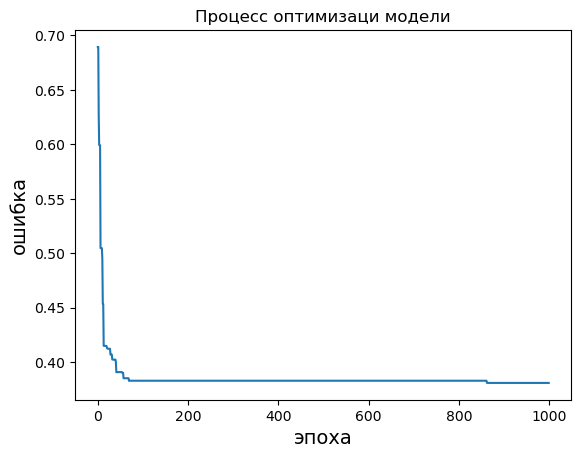

In [123]:
# Печать данных
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:", 
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

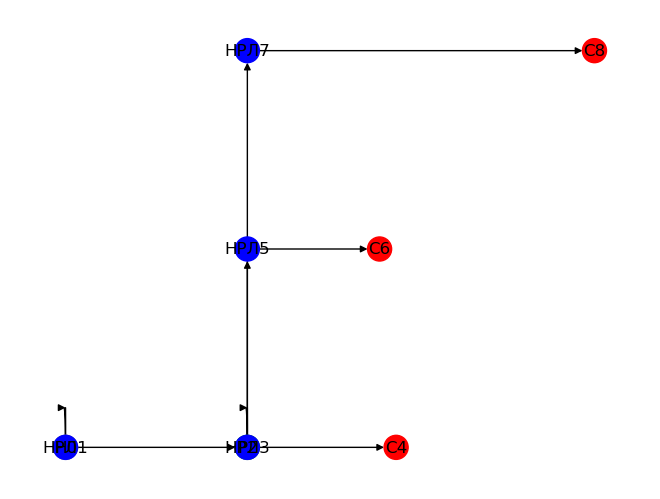

In [141]:
def set_level(elmnt, l=0):
    elmnt.level=l
    for i in range(len(elmnt.elements_next)):
        ne = elmnt.elements_next[i]
        set_level(ne, l+i)

def print_NRS_graph(model, ax=None):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            # print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС с позициями
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    # print(model.getElement(nd).level)
                    level_rize=level
                    cpos = (p,level_rize)
                    cpos = (G.nodes(data=True)[nd]['L'], model.getElement(nd).level)
                    # while cpos in pos_list:
                    #     level_rize+=1
                    #     cpos = (G.nodes(data=True)[nd]['L'], model.getElement(nd).level)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        # nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        # nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        nc = [colors[e.id] for e in model.elmnts]
        if ax:
            nx.draw(G, pos=pos, with_labels=True, node_color=nc, ax=ax)
        else:
            nx.draw(G, pos=pos, with_labels=True, node_color=nc)

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

set_level(work_model.elmnts_in[0])
print_NRS_graph(work_model)

In [134]:
set_level(work_model.elmnts_in[0])

In [136]:
NRS_Revision.print_element_state(work_model.getElement('НРЛ5'))

id: GA_Element_Hose
d: 77
elements_next: [<__main__.GA_Element_Nozzle object at 0x000002203F5FD160>]
elements_previous: [<__main__.GA_Element_Splitter object at 0x000002203EFFA8A0>]
type: 1
name: НРЛ5
q: 5.274352660391511
s: 0.015
H_in: 84.62034751594268
h: 3.338255518341482
z: 0
p: 1
n: 8
q_out: Ellipsis
H_add: 0
observer: None
l: 20
ri: 1
ro: 1
H_out: 81.2820919976012
L: 160
level: 1


In [135]:
work_model.getElement('НРЛ5')

In [128]:
G.nodes(data=True)['Н0']['q']

19.986782960056317